In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_damped_pendulum_data, get_damped_SHM_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics, damped_SHM_dynamics, damped_pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance, get_damped_polynomial_invariance
from damped_invariance_kernel import SHMEpsilonMean, PendulumEpsilonMean, PolynomialEpsilonMean
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

In [37]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.3
testing_time = 3

max_x = 3
max_v = 0.3
n_train = 2
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_SHM_data(0.1, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[ 2.71196497 -2.87824017]
[-0.25907146 -0.20776886]


In [38]:
moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-5
invar_density = 30
latex=""
try:
    kernel = get_damped_SHM_invariance(3, invar_density, jitter) #switch
    known = get_GPR_model(kernel, SHMEpsilonMean(kernel), data, 500)
    print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
    i = 0
    '''
    for poly_f_d in [2]:
        for poly_g_d in [2]:
            kernel = get_damped_polynomial_invariance(3, invar_density, jitter, poly_f_d, poly_g_d) #switch
            m = get_GPR_model(kernel, mean, data, 3000)
            print("(%s, %s)----------------------"%(poly_f_d-1, poly_g_d-1))
            np.set_printoptions(precision=4)
#            print(kernel.f_poly.numpy())
#            print(kernel.g_poly.numpy())
            print(format(m.log_marginal_likelihood().numpy(),".2f"))
            latex+=format(m.log_marginal_likelihood().numpy(),".2f")
            i+=1
            if i%9==0:
                latex+='\\'
            else:
                latex+="&"
    '''
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi:593.33
known: 599.93


In [39]:
print_summary(known)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.mean_function.Ka.variance     │ Parameter │ Sigmoid          │         │ True        │ ()      │ float64 │ 9.999961225405954       │
│ GPR.kernel.Ka.variance            │           │                  │         │             │         │         │                         │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.mean_function.Ka.lengthscales │ Parameter │ Sigmoid          │         │ True        │ (2,)    │ float64 │ [5.31307501 4.75541002] │
│ GPR.kernel.Ka.lengthscale

In [40]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []

grids = (3, 40)
dynamics = damped_SHM_dynamics

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
#lml_inv_p = m.log_marginal_likelihood().numpy()

#grid_moi = (evaluate_model_grid(moi, grids, dynamics))
#grid_inv = (evaluate_model_grid(known, grids, dynamics))
#grid_inv_p = (evaluate_model_grid(m, grids, dynamics))
print(lml_moi)
print(lml_inv)
#print(lml_inv_p)
#def energy(X):
#    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])
def energy(X):
    return 0.5*tf.square(X[:,1])+0.5*tf.square(X[:,0])

for i in range(3):
    print(i)
    test_starting_position = (np.random.uniform(-max_x, max_x))
    test_starting_velocity = (np.random.uniform(-max_v, max_v))

#    print(test_starting_position)
#    print(test_starting_velocity)
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])

#    evaluate_invariance_p =evaluate_model_future(m, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
#    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance[0])


593.327816619814
599.9340831791225
0
0.0101863556822263g
0.06415879110154993g
1
0.007527488195283351
0.0849551082146041gg
2
0.0052412120365156216


KeyboardInterrupt: 

In [6]:
#print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + " & "+' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+ ' \\\\')

MSE & 0.1020 & 0.0357 & nan \\


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


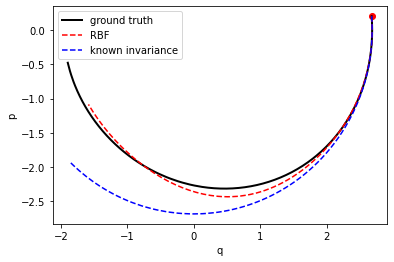

In [30]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
#plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
#plt.savefig("figures/shm_predicted.pdf")

In [125]:

from numpy.polynomial import polynomial
x = np.linspace(-3,3,100)
multiplier = -m.kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.plot(x, -x, label='ground truth', color="black")
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.plot(x, -(x), color="black", label='ground truth')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
#plt.savefig("figures/shm_learnt.pdf")



NameError: name 'm' is not defined

Text(0, 0.5, 'E')

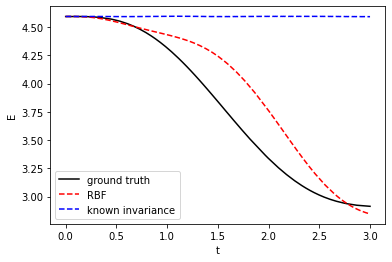

In [31]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="ground truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
#plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/shm_energy.pdf")

In [ ]:

lmls = np.zeros(5)
future = np.zeros((3,5))
dofs = np.zeros(5)
energies = np.zeros((3,5))
moi = get_GPR_model(get_MOI(), mean, data, 500)
lmls[0]=(moi.log_marginal_likelihood().numpy())
dofs[0] = degree_of_freedom(moi.kernel, np.radians(150),40,moi.likelihood.variance.numpy())
invar_density=20
for i in range(3):
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))
    test_starting = (test_starting_position, test_starting_velocity)
    for j, jitter in enumerate([7e-6, 1e-5, 5e-5, 9e-5]):
        print(invar_density)
        try:
            kernel = get_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
            m = get_GPR_model(kernel, mean, data, 500)
        except tf.errors.InvalidArgumentError:
            print("jitter too small")
            break 
        lmls[j+1]=(m.log_marginal_likelihood().numpy())
        dofs[j+1] = degree_of_freedom(m.kernel, np.radians(150),40,m.likelihood.variance.numpy())
        print(m.log_marginal_likelihood().numpy())

    #        print(test_starting_position)
    #        print(test_starting_velocity)

        evaluate_moi = evaluate_model_future(moi, test_starting, dynamics, time_setting, energy)

        future[i,0]=(evaluate_moi[0])
        energies[i,0]=abs((evaluate_moi[6][-1]-evaluate_moi[6][0])/evaluate_moi[6][0])

        evaluate_invariance = evaluate_model_future(m, test_starting, dynamics, time_setting, energy)
        print(format(evaluate_invariance[0],".4f"))
        future[i,j+1] = (evaluate_invariance[0])
        energies[i,j+1]=abs((evaluate_invariance[6][-1]-evaluate_invariance[6][0])/evaluate_invariance[6][0])



In [ ]:

test_range = 5
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred = tf.zeros((test_points.shape[0], 1), dtype=tf.float64)
#var = tf.linalg.diag_part(get_pendulum_invariance(np.radians(150), invar_density, jitter)(test_points))
#var = tf.linalg.diag_part(get_SHM_invariance(5, invar_density, jitter)(test_points))
var = tf.linalg.diag_part(get_MOI()(test_points))
X, Y = data
pred_a = pred
var_a = var[:int(var.shape[0]/2)]
pred_v = pred
var_v = var[int(var.shape[0]/2):]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("RBF GP Prior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.8)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("RBF GP Prior of v")
plt.savefig("figures/prior_shm_rbf.pdf")